In [1]:
import sys
sys.path.append("../")

import yaml
import matplotlib.pyplot as plt
import cattrs
from typing import List
#from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict
from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict

In [2]:
def read_experiments(experimnt_history):
    with open(experimnt_history, 'r') as f:
        obj = yaml.safe_load(f)
    
    experiments = cattrs.structure(obj, List[Experiment])
    return experiments


def get_experiment_result(experiment: Experiment):
    val_results: List[Dict[str, ValResult]] = []
    domain_weights: List[Dict[str, float]] = []
    weighted_perplexity = []
    for i, trial in enumerate(experiment.trials):
        if not trial.weighted_val_perplexity:
            print(f"Trial {i} did not finish yet. Breaking")
            break
        val_results.append(trial.val_results)
        weighted_perplexity.append(trial.weighted_val_perplexity)
        domain_weights.append(trial.true_mixing_weights)
    return val_results, weighted_perplexity, domain_weights

def plot_weighted_val_perplexity(weighted_val_perplexities: List[float], no_initial_runs: int = 0):
    plt.plot(weighted_val_perplexities)
    plt.scatter(range(len(weighted_val_perplexities)), weighted_val_perplexities)
    plt.axvline(x=no_initial_runs - 1, color='r', linestyle='--')
    plt.xlabel('Run')
    plt.ylabel('Weighted Val Perplexity')
    plt.title('Weighted Val Perplexity')

def plot_domain_perplexities(val_results: List[Dict[str, ValResult]], no_initial_runs: int = 0):
    max_plots_per_row = 4
    domains = val_results[0].keys()
    num_plots = len(domains)
    num_rows = num_plots // max_plots_per_row + 1
    num_cols = min(num_plots, max_plots_per_row)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
    fig.suptitle('Domain Perplexities')
    axs = axs.flatten()

    for i, domain in enumerate(domains):
        domain_perplexities = [val_result[domain].perplexity for val_result in val_results]
        axs[i].plot(domain_perplexities)
        axs[i].set_title(domain)
        axs[i].set_xlabel('Run')
        axs[i].set_ylabel('Perplexity')
        axs[i].axvline(x=no_initial_runs - 1, color='r', linestyle='--')
        axs[i].scatter(range(len(domain_perplexities)), domain_perplexities)
    plt.tight_layout()  

def plot_mixing_weights(mixing_weights: List[Dict[str, float]], no_initial_runs: int = 0):
    max_plots_per_row = 4
    domains = mixing_weights[0].keys()
    num_plots = len(domains)
    num_rows = num_plots // max_plots_per_row + 1
    num_cols = min(num_plots, max_plots_per_row)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
    fig.suptitle('Mixing Weights')
    axs = axs.flatten()

    for i, domain in enumerate(domains):
        mix_w = [weight[domain] for weight in mixing_weights]
        axs[i].plot(mix_w)
        axs[i].set_title(domain)
        axs[i].set_xlabel('Run')
        axs[i].set_ylabel('Mixing Weight')
        axs[i].legend()
        axs[i].axvline(x=no_initial_runs - 1, color='r', linestyle='--')
        axs[i].scatter(range(len(mix_w)), mix_w)
    plt.tight_layout()  

In [3]:
path = "/root/code/mixture_optimization/logs/lin_interp_books_cc_0/experiment_history.yaml"
experiments = read_experiments(path)
experiment = experiments[0]

Best perplexity: 4.419858053326607 at mixing weight: 0.4286459862347914


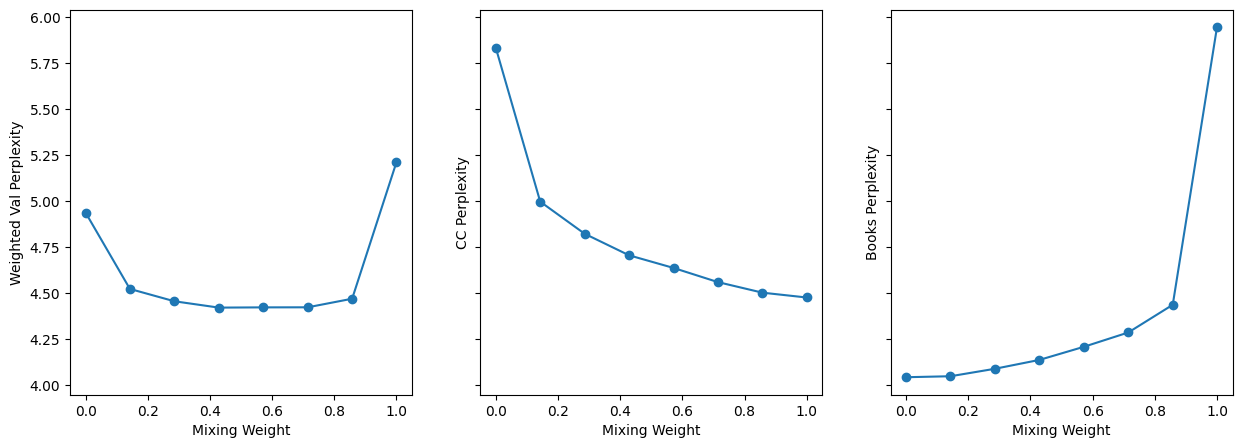

In [4]:
cc_weights = []
cc_res = []
books_res = []
res = []

for trial in experiment.trials:
    book_weight = trial.true_mixing_weights['Books']
    cc_weight = trial.true_mixing_weights['CC']

    books_res.append(trial.val_results['Books'].perplexity)
    cc_res.append(trial.val_results['CC'].perplexity)
    

    cc_weights.append(cc_weight)
    res.append(trial.weighted_val_perplexity)

# create 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# plot 1
axs[0].plot(cc_weights, res, '-o')
axs[0].set_xlabel('Mixing Weight CC')
axs[0].set_ylabel('Weighted Val Perplexity')

# plot 2
axs[1].plot(cc_weights, cc_res, '-o')
axs[1].set_xlabel('Mixing Weight CC')
axs[1].set_ylabel('CC Perplexity')

# plot 3
axs[2].plot(cc_weights, books_res, '-o')
axs[2].set_xlabel('Mixing Weight Book')
axs[2].set_ylabel('Books Perplexity')

best_perplexity = min(res)
best_idx = res.index(best_perplexity)

print(f"Best perplexity: {best_perplexity} at mixing weight: {cc_weights[best_idx]}")

    

In [5]:
path2 = "/root/code/mixture_optimization/logs/turbo-two-sources_1/experiment_history.yaml"
experiments2 = read_experiments(path2)
experiment2 = experiments2[0]

Best perplexity: 4.40161557495594 at mixing weight: 0.536204347022431
Best idx: 22


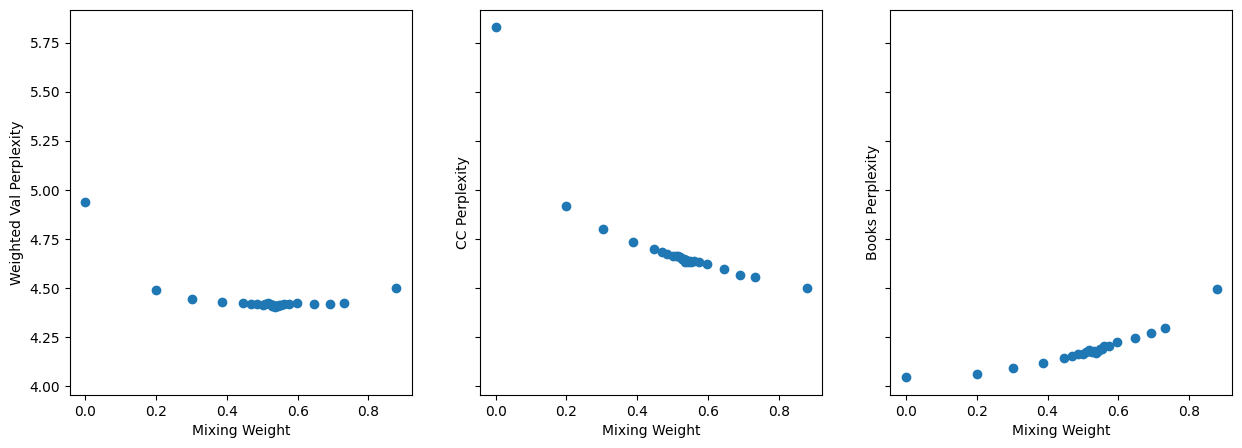

In [6]:
cc_weights = []
cc_res = []
books_res = []
res = []
max_trials = -1

for i, trial in enumerate(experiment2.trials[:max_trials]):
    if not trial.weighted_val_perplexity:
        print(f"Trial {i} did not finish yet. Breaking")
        break
    book_weight = trial.true_mixing_weights['Books']
    cc_weight = trial.true_mixing_weights['CC']

    books_res.append(trial.val_results['Books'].perplexity)
    cc_res.append(trial.val_results['CC'].perplexity)
    

    cc_weights.append(cc_weight)
    res.append(trial.weighted_val_perplexity)

# create 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# plot 1
axs[0].scatter(cc_weights, res)
axs[0].set_xlabel('Mixing Weight CC')
axs[0].set_ylabel('Weighted Val Perplexity')

# plot 2
axs[1].scatter(cc_weights, cc_res)
axs[1].set_xlabel('Mixing Weight CC')
axs[1].set_ylabel('CC Perplexity')

# plot 3
axs[2].scatter(cc_weights, books_res)
axs[2].set_xlabel('Mixing Weight Book')
axs[2].set_ylabel('Books Perplexity')

best_perplexity = min(res)
best_idx = res.index(best_perplexity)

print(f"Best perplexity: {best_perplexity} at mixing weight: {cc_weights[best_idx]}")
print(f"Best idx: {best_idx}")

    

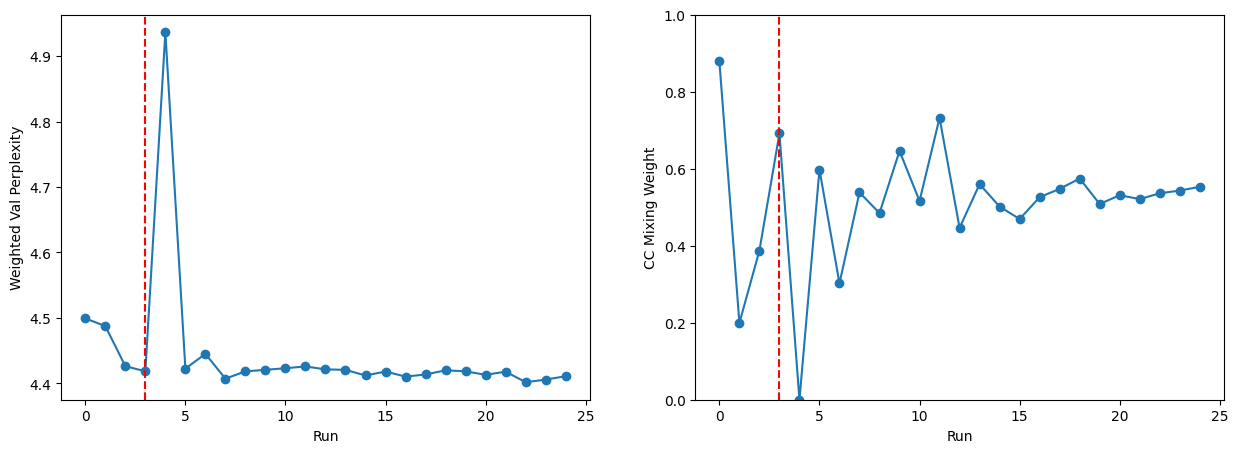

In [7]:
start_teratrions = 4

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plot weighte val perpleixty over time
axs[0].plot(res, '-o')
axs[0].set_xlabel('Run')
axs[0].set_ylabel('Weighted Val Perplexity')
axs[0].axvline(x=start_teratrions - 1, color='r', linestyle='--')

# plot cc weights over time
axs[1].plot(cc_weights, '-o')
axs[1].set_xlabel('Run')
axs[1].set_ylabel('CC Mixing Weight')
axs[1].set_ylim([0, 1])
axs[1].axvline(x=start_teratrions - 1, color='r', linestyle='--')


In [8]:
path3 = "/root/code/mixture_optimization/logs/bayesian-two-sources_0/experiment_history.yaml"
experiments3 = read_experiments(path3)
experiment3 = experiments3[0]

Best perplexity: 4.406554162502289 at mixing weight: 0.4718987506931533
Best idx: 7


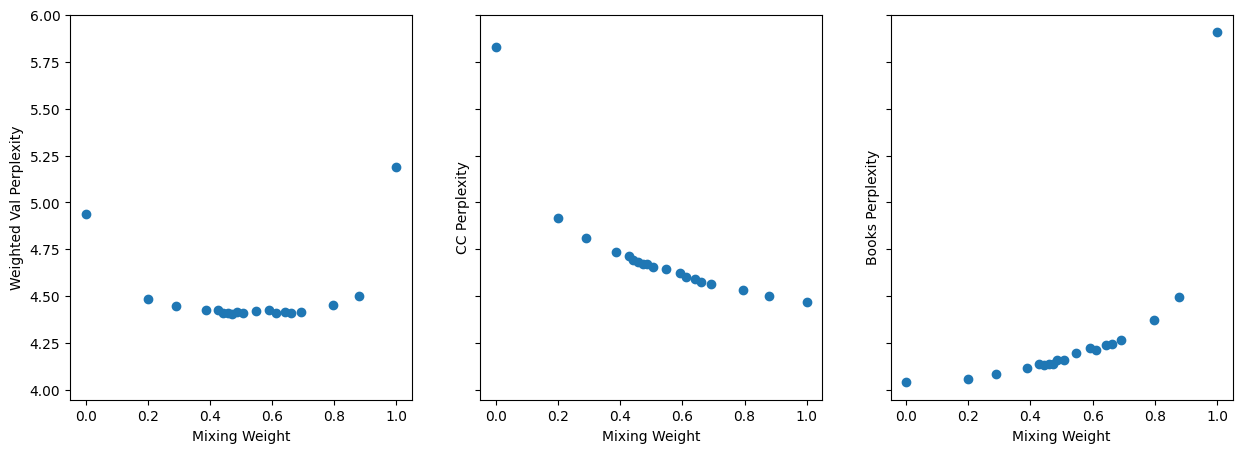

In [9]:
cc_weights = []
cc_res = []
books_res = []
res = []
max_trials = -1

for i, trial in enumerate(experiment3.trials[:max_trials]):
    if not trial.weighted_val_perplexity:
        print(f"Trial {i} did not finish yet. Breaking")
        break
    book_weight = trial.true_mixing_weights['Books']
    cc_weight = trial.true_mixing_weights['CC']

    books_res.append(trial.val_results['Books'].perplexity)
    cc_res.append(trial.val_results['CC'].perplexity)
    

    cc_weights.append(cc_weight)
    res.append(trial.weighted_val_perplexity)

# create 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# plot 1
axs[0].scatter(cc_weights, res)
axs[0].set_xlabel('Mixing Weight CC')
axs[0].set_ylabel('Weighted Val Perplexity')

# plot 2
axs[1].scatter(cc_weights, cc_res)
axs[1].set_xlabel('Mixing Weight CC')
axs[1].set_ylabel('CC Perplexity')

# plot 3
axs[2].scatter(cc_weights, books_res)
axs[2].set_xlabel('Mixing Weight Books')
axs[2].set_ylabel('Books Perplexity')

best_perplexity = min(res)
best_idx = res.index(best_perplexity)

print(f"Best perplexity: {best_perplexity} at mixing weight: {cc_weights[best_idx]}")
print(f"Best idx: {best_idx}")

    

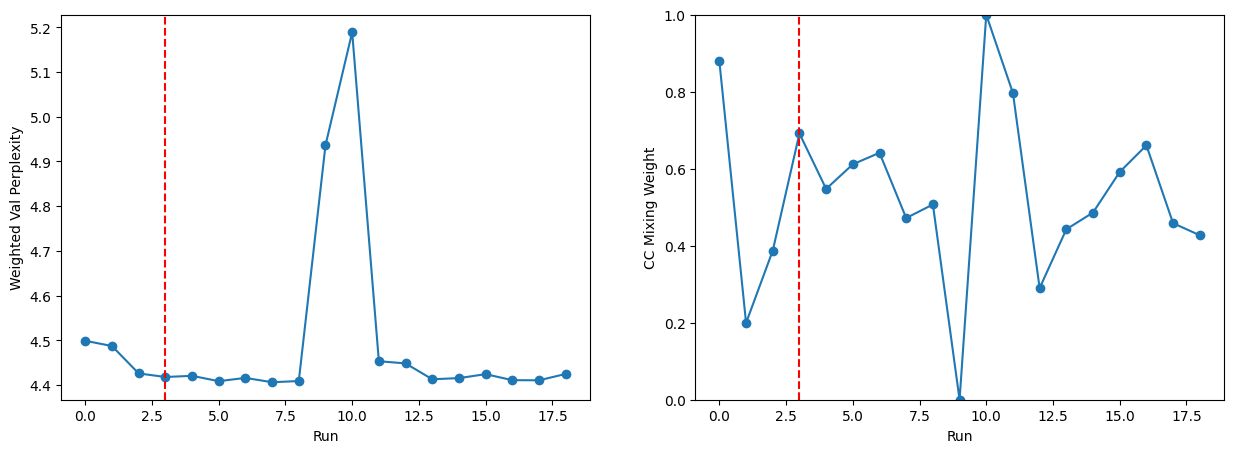

In [10]:
start_teratrions = 4

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plot weighte val perpleixty over time
axs[0].plot(res, '-o')
axs[0].set_xlabel('Run')
axs[0].set_ylabel('Weighted Val Perplexity')
axs[0].axvline(x=start_teratrions - 1, color='r', linestyle='--')

# plot cc weights over time
axs[1].plot(cc_weights, '-o')
axs[1].set_xlabel('Run')
axs[1].set_ylabel('CC Mixing Weight')
axs[1].set_ylim([0, 1])
axs[1].axvline(x=start_teratrions - 1, color='r', linestyle='--')